# Assignment 2 - Applying convolution networks (convnets) to image data

### Downloading the data

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prajwalcn007","key":"ecc02c67ba65955f65a8598a251293b6"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 99% 803M/812M [00:05<00:00, 201MB/s]
100% 812M/812M [00:05<00:00, 166MB/s]


In [5]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

# Training the convent network from scratch

## Model 1 - Training sample of 2000, a validation sample of 1000, and a test sample of 1000.

**Using `image_dataset_from_directory` to read images and Spliting data for train, validation and test**

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

# Spliting data for train, validation and test
make_subset("train_1", start_index=0, end_index=1000)
make_subset("validation_1", start_index=1000, end_index=1500)
make_subset("test_1", start_index=1500, end_index=2000)

train_dataset_1 = image_dataset_from_directory(
    new_base_dir / "train_1",
    image_size=(180, 180),
    batch_size=32)
validation_dataset_1 = image_dataset_from_directory(
    new_base_dir / "validation_1",
    image_size=(180, 180),
    batch_size=32)
test_dataset_1 = image_dataset_from_directory(
    new_base_dir / "test_1",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


**Defining a new convnet that includes data augmentation, dropouts, regularization("L2 form") & early stopping**

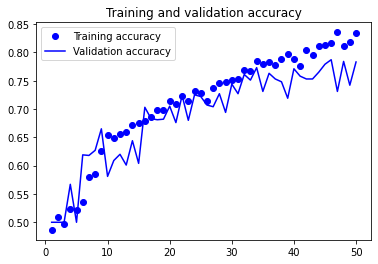

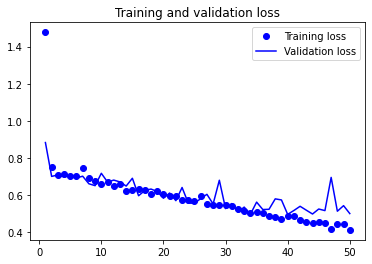

32/32 [==============================] - 1s 18ms/step - loss: 0.5105 - accuracy: 0.7710
Test accuracy: 0.771


In [38]:
from tensorflow import keras
from tensorflow.keras import layers
# Import EarlyStopping
from keras.callbacks import EarlyStopping
# Importing regularizers from keras package
from keras import regularizers

# data_augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# convnet that includes dropouts, regularization("L2 form") & early stopping
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", kernel_regularizer = regularizers.l2( l=0.01))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = keras.Model(inputs=inputs, outputs=outputs)

model_1.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)

# Training the regularized convnet
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history_1 = model_1.fit(
    train_dataset_1,
    epochs=100,
    validation_data=validation_dataset_1,
    callbacks=callbacks, verbose=False)

# Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
accuracy = history_1.history["accuracy"]
val_accuracy = history_1.history["val_accuracy"]
loss = history_1.history["loss"]
val_loss = history_1.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


# Evaluating the model on the test set
test_model_1 = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model_1.evaluate(test_dataset_1)
print(f"Test accuracy: {test_acc:.3f}")

*Model-1 Performance metric:*

**Accuracy** 

Train Accuracy: 80.55%   
Valid Accuracy: 78.85%  
Test Accuracy : 77.10%  

**Loss Value**  
Train Loss: 0.4305  
Valid Loss: 0.4829  
Test Loss : 0.5105  


As you can see, we got **Test Accuracy : 77.10%**. In the next model will try to increase the training sample size and train convents from strach, and we will see whether we can able to increase the test accuracy even further.

## Model 2 - Increasing training sample to 12000, and keeping same validation sample of 1000, and a test sample of 1000.

**Using `image_dataset_from_directory` to read images and Spliting data for train, validation and test**

In [43]:
from tensorflow.keras.utils import image_dataset_from_directory

# Spliting data for train, validation and test
make_subset("train_2", start_index=0, end_index=6000)
make_subset("validation_2", start_index=6000, end_index=6500)
make_subset("test_2", start_index=6500, end_index=7000)

train_dataset_2 = image_dataset_from_directory(
    new_base_dir / "train_2",
    image_size=(180, 180),
    batch_size=32)
validation_dataset_2 = image_dataset_from_directory(
    new_base_dir / "validation_2",
    image_size=(180, 180),
    batch_size=32)
test_dataset_2 = image_dataset_from_directory(
    new_base_dir / "test_2",
    image_size=(180, 180),
    batch_size=32)

Found 12000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


**Defining a new convnet that includes data augmentation, dropouts, regularization("L2 form") & early stopping**

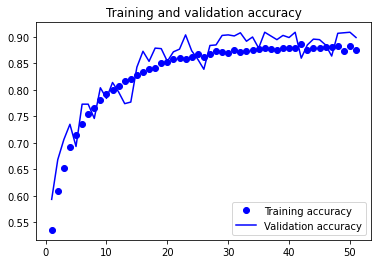

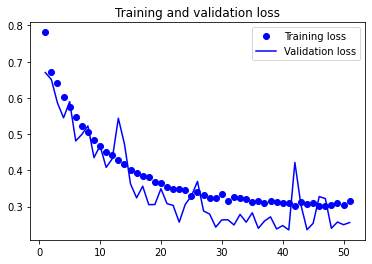

32/32 [==============================] - 1s 17ms/step - loss: 0.2752 - accuracy: 0.8900
Test accuracy: 0.890


In [44]:
from tensorflow import keras
from tensorflow.keras import layers
# Import EarlyStopping
from keras.callbacks import EarlyStopping
# Importing regularizers from keras package
from keras import regularizers

# data_augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer = regularizers.l2( l=0.01))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = keras.Model(inputs=inputs, outputs=outputs)

model_2.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])

# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)

# Training the regularized convnet
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history_2 = model_2.fit(
    train_dataset_2,
    epochs=100,
    validation_data=validation_dataset_2,
    callbacks=callbacks, verbose=False)

# Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
accuracy = history_2.history["accuracy"]
val_accuracy = history_2.history["val_accuracy"]
loss = history_2.history["loss"]
val_loss = history_2.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


# Evaluating the model on the test set
test_model_2 = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model_2.evaluate(test_dataset_2)
print(f"Test accuracy: {test_acc:.3f}")

*Model-2 Performance metric:*

**Accuracy** 

Train Accuracy: 87.55%   
Valid Accuracy: 87.35%  
Test Accuracy : 89.00%  

**Loss Value**  
Train Loss: 0.3805  
Valid Loss: 0.3305  
Test Loss : 0.2752

As you can see, we got **Test Accuracy : 89.00%**. Almost 11% better than Model-1. In the next model will try to increase the training sample size to the maximum and train convents from strach, and we will see whether we can able to increase the test accuracy even further.

## Model 3 - Trying with maximum datapoints available in dataset with training sample of 23000, and keeping same validation sample of 1000, and a test sample of 1000.

**Using `image_dataset_from_directory` to read images and Spliting data for train, validation and test**

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

# Spliting data for train, validation and test
make_subset("train_3", start_index=0, end_index=11500)
make_subset("validation_3", start_index=11500, end_index=12000)
make_subset("test_3", start_index=12000, end_index=12500)

train_dataset_3 = image_dataset_from_directory(
    new_base_dir / "train_3",
    image_size=(180, 180),
    batch_size=32)
validation_dataset_3 = image_dataset_from_directory(
    new_base_dir / "validation_3",
    image_size=(180, 180),
    batch_size=32)
test_dataset_3 = image_dataset_from_directory(
    new_base_dir / "test_3",
    image_size=(180, 180),
    batch_size=32)

Found 23000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


**Defining a new convnet that includes data augmentation, dropouts, regularization("L2 form") & early stopping**

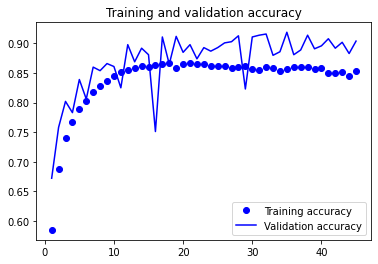

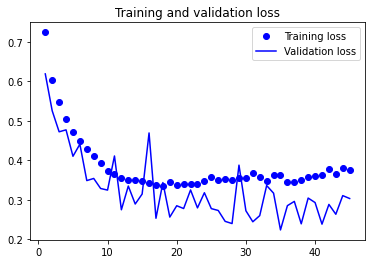

32/32 [==============================] - 1s 17ms/step - loss: 0.2027 - accuracy: 0.9280
Test accuracy: 0.928


In [35]:
from tensorflow import keras
from tensorflow.keras import layers
# Import EarlyStopping
from keras.callbacks import EarlyStopping
# Importing regularizers from keras package
from keras import regularizers

# data_augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer = regularizers.l2( l=0.01))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = keras.Model(inputs=inputs, outputs=outputs)

model_3.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])

# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)

# Training the regularized convnet
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history_3 = model_3.fit(
    train_dataset_3,
    epochs=100,
    validation_data=validation_dataset_3,
    callbacks=callbacks, verbose=False)

# Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
accuracy = history_3.history["accuracy"]
val_accuracy = history_3.history["val_accuracy"]
loss = history_3.history["loss"]
val_loss = history_3.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


# Evaluating the model on the test set
test_model_3 = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model_3.evaluate(test_dataset_3)
print(f"Test accuracy: {test_acc:.3f}")

*Model-3 Performance metric:*

**Accuracy** 

Train Accuracy: 87.55%   
Valid Accuracy: 90.35%  
Test Accuracy : 92.80%  

**Loss Value**  
Train Loss: 0.3805  
Valid Loss: 0.2059  
Test Loss : 0.2027  

As you can see, we got **Test Accuracy : 92.80%**. Almost 3% better than Model-2. So more training data is better for models, when we are training from strach. In next model will use pretrained network and see whether we can able to increase the test accuracy even further.



# VGG16 Pretrained Convnet Network



## Pretrained Model-1 - Training sample of 2000, a validation sample of 1000, and a test sample of 1000.

## Using Feature Extraction with Data Augmentation and Fine-tuning

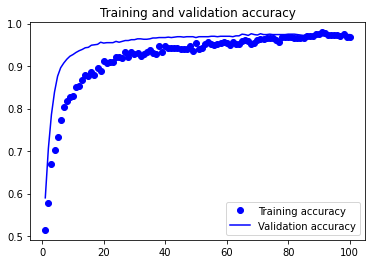

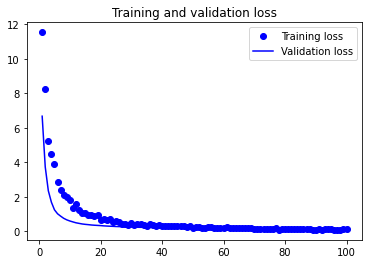

32/32 [==============================] - 2s 58ms/step - loss: 0.1617 - accuracy: 0.9790
Test accuracy: 0.979


In [19]:
from tensorflow import keras
from tensorflow.keras import layers

# Instantiating the VGG16 convolutional base
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_pre_trained_1 = keras.Model(inputs, outputs)
# Fine-tuning the model
model_pre_trained_1.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-6),
              metrics=["accuracy"])

# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]

history_pre_trained_1 = model_pre_trained_1.fit(
    train_dataset_1,
    epochs=100,
    validation_data=validation_dataset_1,
    callbacks=callbacks, verbose=False)

# Plotting the results
import matplotlib.pyplot as plt
acc = history_pre_trained_1.history["accuracy"]
val_acc = history_pre_trained_1.history["val_accuracy"]
loss = history_pre_trained_1.history["loss"]
val_loss = history_pre_trained_1.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Test accuracy
model_pre_trained_1 = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model_pre_trained_1.evaluate(test_dataset_1)
print(f"Test accuracy: {test_acc:.3f}")

*Pretrained model-1 Performance metric:*

**Accuracy** 

Train Accuracy: 98.55%   
Valid Accuracy: 98.35%  
Test Accuracy : 97.90%  

**Loss Value**  
Train Loss: 0.1580  
Valid Loss: 0.1602  
Test Loss : 0.1617  

As you can see, we got **Test Accuracy : 97.90%**. much better than models trained from scratch.    


## Pretrained Model-2 - Training sample of 23000, a validation sample of 1000, and a test sample of 1000.




## Using Feature Extraction with Data Augmentation and Fine-tuning

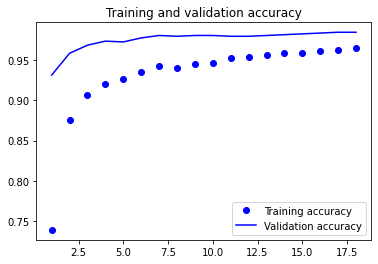

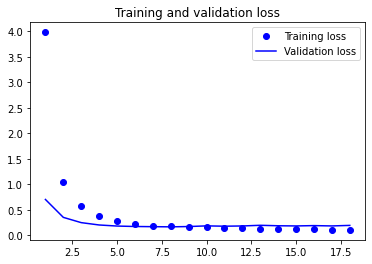

32/32 [==============================] - 2s 57ms/step - loss: 0.0975 - accuracy: 0.9760
Test accuracy: 0.976


In [20]:
from tensorflow import keras
from tensorflow.keras import layers

# Instantiating the VGG16 convolutional base
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_pre_trained_2 = keras.Model(inputs, outputs)
# Fine-tuning the model
model_pre_trained_2.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-6),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
        ]

history_pre_trained_2 = model_pre_trained_2.fit(
    train_dataset_3,
    epochs=100,
    validation_data=validation_dataset_3,
    callbacks=callbacks, verbose=False)

# Plotting the results
import matplotlib.pyplot as plt
acc = history_pre_trained_2.history["accuracy"]
val_acc = history_pre_trained_2.history["val_accuracy"]
loss = history_pre_trained_2.history["loss"]
val_loss = history_pre_trained_2.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Test accuracy
model_pre_trained_3 = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model_pre_trained_3.evaluate(test_dataset_3)
print(f"Test accuracy: {test_acc:.3f}")

*Pretrained model-2 Performance metric:*

**Accuracy** 

Train Accuracy: 96.55%   
Valid Accuracy: 97.85%  
Test Accuracy : 97.60%  

**Loss Value**  
Train Loss: 0.1203  
Valid Loss: 0.1021  
Test Loss : 0.0975  

As you can see, we got **Test Accuracy : 97.60%**. which is similar to Pretrained model-1 but much better than models trained from scratch.

## To Summarise:

**Plotting Validation Accuracy by comparing all above models**

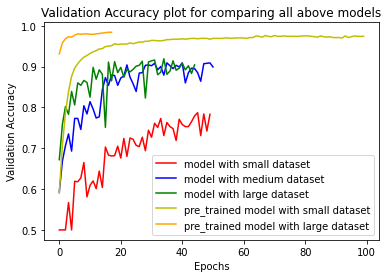

In [53]:
# Create the plot
plt.plot(history_1.history['val_accuracy'] , 'r', label='model with small dataset')
plt.plot(history_2.history['val_accuracy'] ,  'b', label='model with medium dataset')
plt.plot(history_3.history['val_accuracy'] , 'g', label='model with large dataset')
plt.plot(history_pre_trained_1.history['val_accuracy'] ,  'y', label='pre_trained model with small dataset')
plt.plot(history_pre_trained_2.history['val_accuracy'] , 'orange', label='pre_trained model with large dataset')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title("Validation Accuracy plot for comparing all above models")

plt.show()

**Plotting Validation loss by comparing all above models**

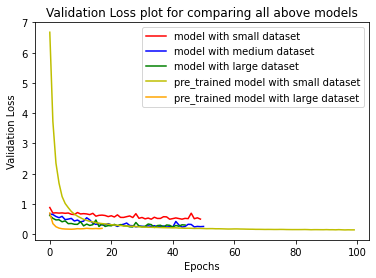

In [54]:
# Create the plot
plt.plot(history_1.history['val_loss'] , 'r', label='model with small dataset')
plt.plot(history_2.history['val_loss'] ,  'b', label='model with medium dataset')
plt.plot(history_3.history['val_loss'] , 'g', label='model with large dataset')
plt.plot(history_pre_trained_1.history['val_loss'] ,  'y', label='pre_trained model with small dataset')
plt.plot(history_pre_trained_2.history['val_loss'] , 'orange', label='pre_trained model with large dataset')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title("Validation Loss plot for comparing all above models")

plt.show()

**Plotting the nerual network graph for pretrained and models trained from strach**

### Models trained from strach

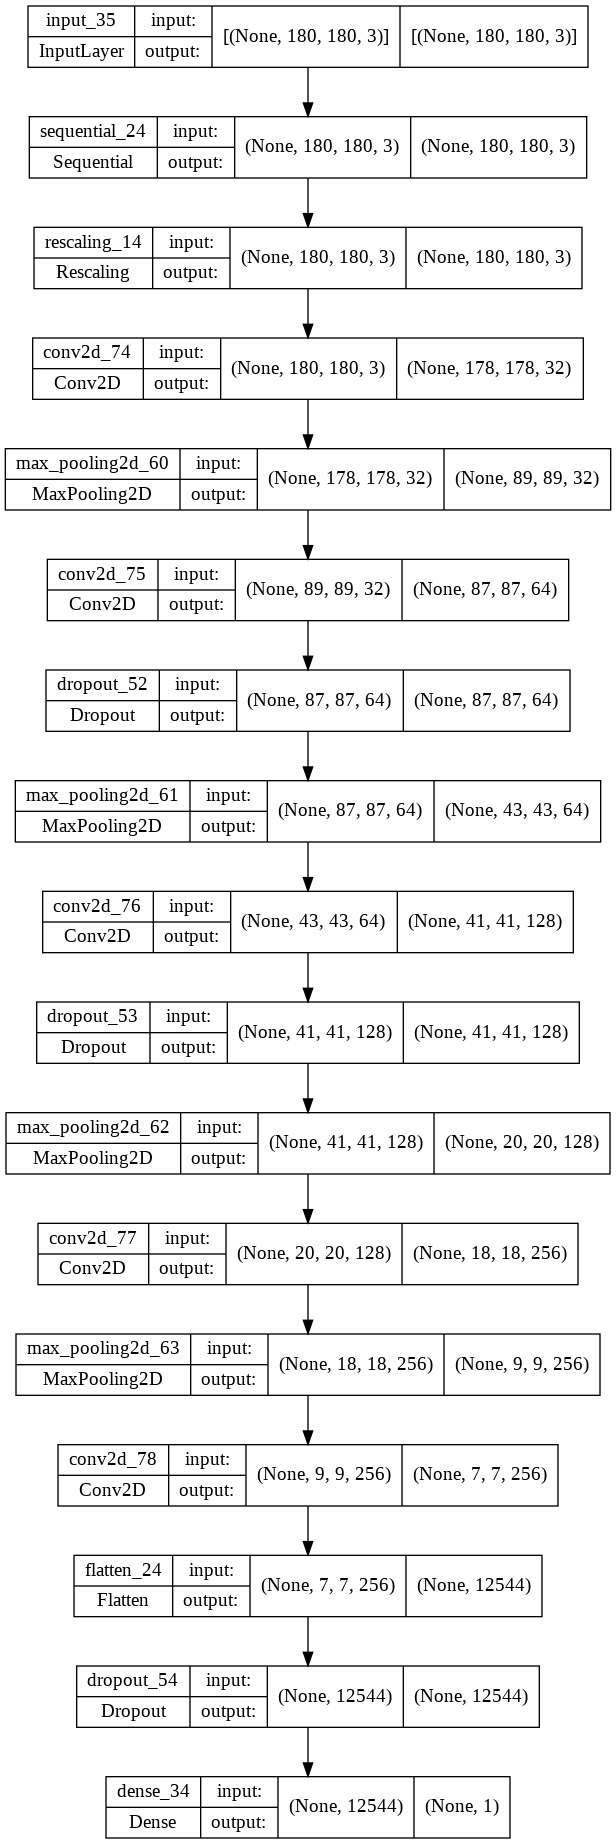

In [57]:
# plot of the network neural network graph
from keras.utils.vis_utils import plot_model
from keras import models 
from keras_visualizer import visualizer 
plot_model(model_3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Pretrained Models

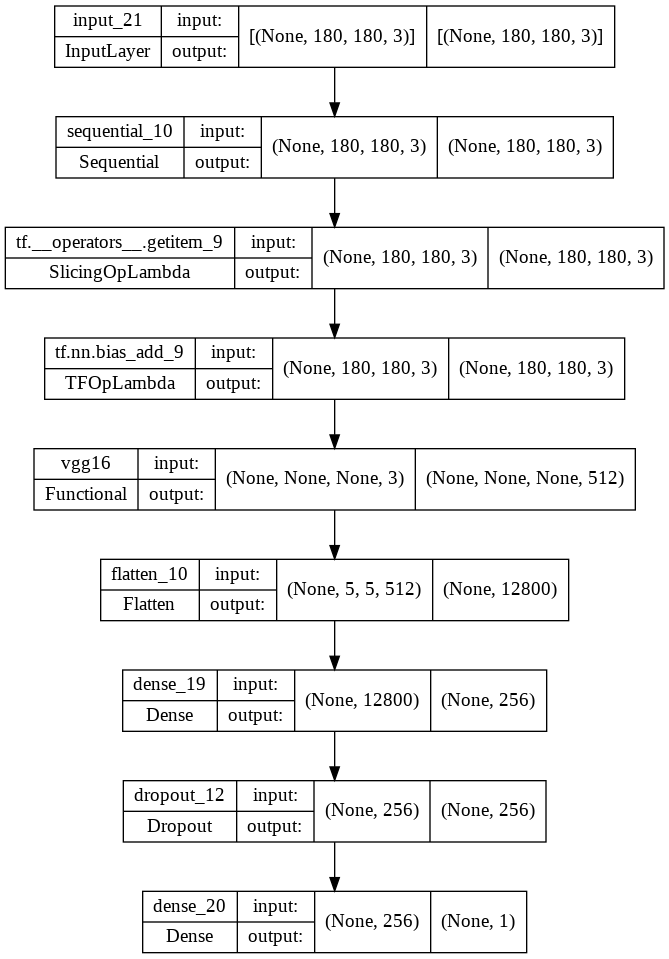

In [59]:
# plot of the network neural network graph
from keras.utils.vis_utils import plot_model
from keras import models 
from keras_visualizer import visualizer 
plot_model(model_pre_trained_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model trainined from sratch used total parameters of **991,041**, while pretrained model has total parameters of **17,992,001**

**To conclude,** the results of this test are apparent; using a pre-trained model for many image recognition tasks is beneficial for several reasons. 

1) Using a pre-trained model requires less training and requires less effort in building the model’s architecture.   

2) Using a pre-trained model is significantly more accurate than using a custom-built convolutionary neural network (CNN).    

3) We can see that large sample size helps the model learn better when we train the model from scratch. In a pretrained model, we can improve the outcome by unfreezing a few of the top layers of a frozen model and jointly training
both the newly added part of the model.  

4) Overfitting will be the major concern with a little dataset. When working with image data, data augmentation is a strong approach to combat overfitting.  

5) Using feature extraction, it's simple to reuse an old convnet on a new dataset. When working with tiny picture collections, this is a useful strategy.  

6) Fine-tuning is a technique that applies some of the representations already learnt by an existing model to a new challenge as a supplement to feature extraction. This raises the bar for performance.